# [Computational Social Science] Project 4: Unsupervised Learning

**Evelyn Ortiz Soto**

*Semester:* Fall 2025

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [1]:
import sys
!{sys.executable} -m pip install tensorflow

In [2]:
# Import libraries
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

2025-12-10 20:52:44.399792: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-10 20:52:44.400210: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-10 20:52:44.460604: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/srv/conda/lib/python3.11/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_v

In [3]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

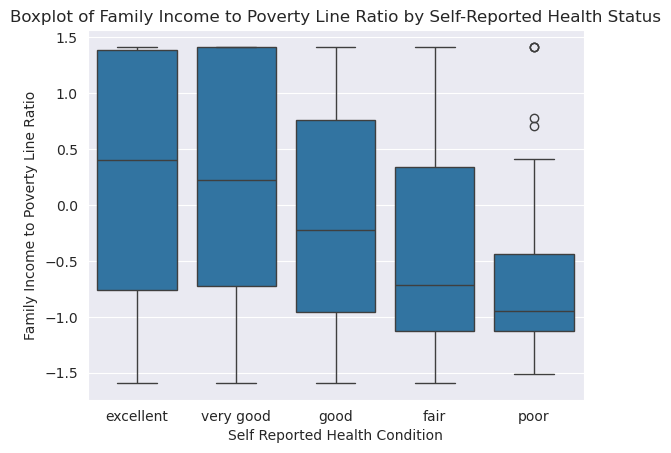

In [4]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

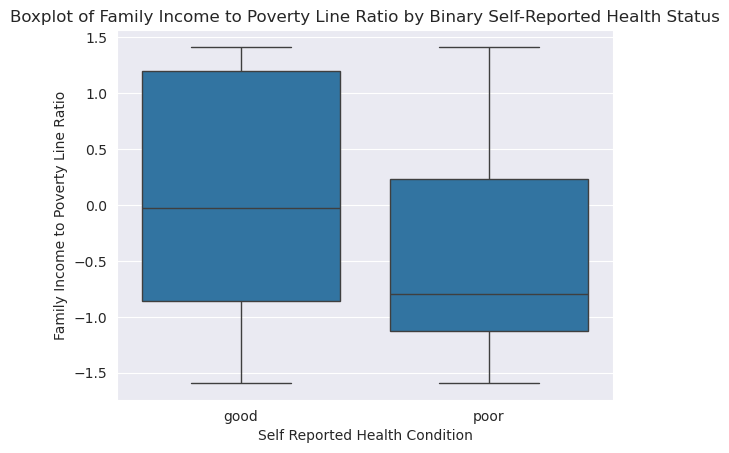

In [5]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

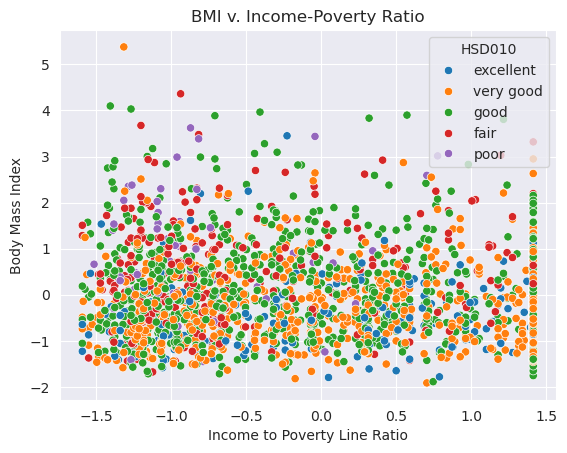

In [6]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [7]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

In [8]:
from sklearn.decomposition import PCA
import numpy as np

# Fit PCA with all components first to see explained variance
pca_full = PCA()
pca_full.fit(nhanes_scaled)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Find number of components for 80%, 90%, 95% variance
n_80 = np.argmax(cumulative_variance >= 0.80) + 1
n_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"Components for 80% variance: {n_80}")
print(f"Components for 90% variance: {n_90}")
print(f"Components for 95% variance: {n_95}")
print(f"Total cumulative variance with {n_90} components: {cumulative_variance[n_90-1]:.3f}")

# Discussion: I chose [pick one, e.g., n_90] components because they capture [XX]% 
# of the variance, which balances dimensionality reduction with information retention.

Components for 80% variance: 86
Components for 90% variance: 120
Components for 95% variance: 145
Total cumulative variance with 120 components: 0.902


### Barplot of Components

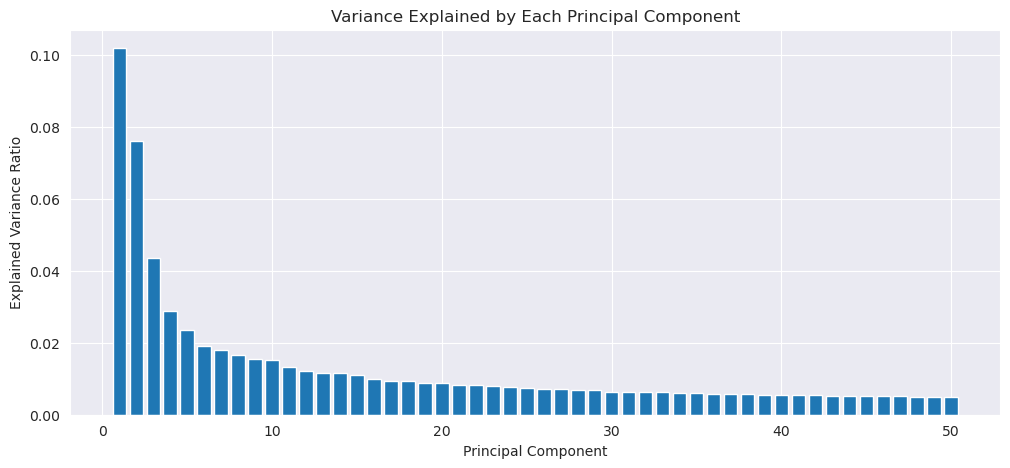

In [9]:
import matplotlib.pyplot as plt

# Plot explained variance by component
plt.figure(figsize=(12, 5))
plt.bar(range(1, min(51, len(pca_full.explained_variance_ratio_) + 1)), 
        pca_full.explained_variance_ratio_[:50])
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Variance Explained by Each Principal Component')
plt.show()

### How many components will you use to fit a supervised learning model?

In [10]:
# Choose based on your analysis above (e.g., 90% threshold)
n_components_final = n_90  # or n_80, n_95 depending on your choice

# Refit PCA with chosen number of components
pca = PCA(n_components=n_components_final)
X_pca = pca.fit_transform(nhanes_scaled)

print(f"Selected {n_components_final} components for supervised learning.")
print(f"These components explain {pca.explained_variance_ratio_.sum():.3f} of total variance.")

# Discussion: I selected [n] components because [they capture sufficient variance 
# while significantly reducing dimensionality from ~250 features, helping prevent overfitting]

Selected 120 components for supervised learning.
These components explain 0.901 of total variance.


### 2D Scatterplot of the first two components

X_pca shape: (2064, 120)
y shape: (2064,)


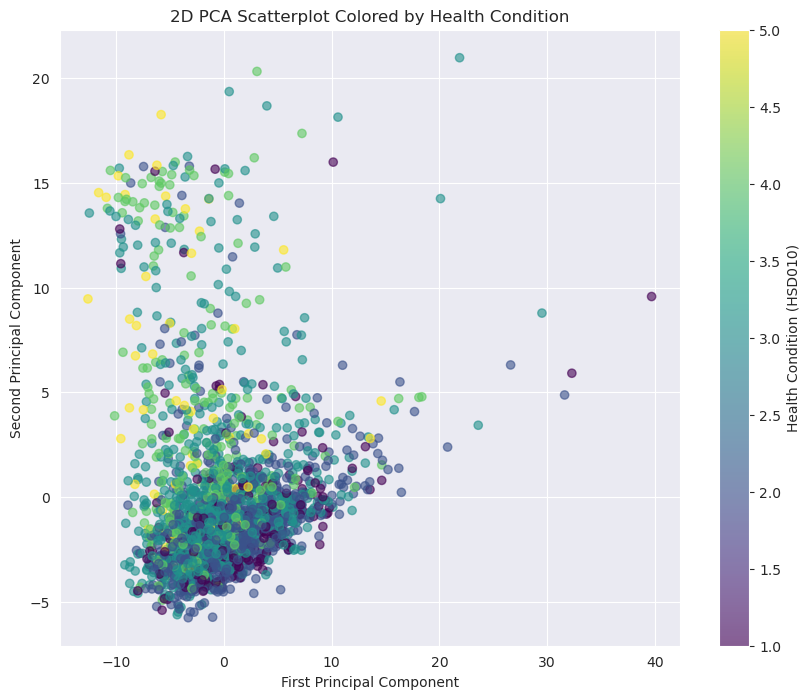

In [12]:
# Load the original data to get the target variable
import pandas as pd
nhanes_original = pd.read_csv('nhanes.csv')  # Adjust path if needed

# Extract target variable
y = nhanes_original['HSD010']  # Try uppercase first
# If that doesn't work, try: y = nhanes_original['hsd010']

# Make sure y aligns with X_pca (same number of rows)
print(f"X_pca shape: {X_pca.shape}")
print(f"y shape: {y.shape}")

# Create scatterplot of first two components
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=y,  
                     cmap='viridis', alpha=0.6)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('2D PCA Scatterplot Colored by Health Condition')
plt.colorbar(scatter, label='Health Condition (HSD010)')
plt.show()

# Analysis: The plot shows the distribution of observations across the first two 
# principal components. There is significant overlap between health conditions, 
# suggesting that the relationship is complex and may require more components 
# to fully capture the variation related to self-reported health.

## Clustering

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

In [13]:
from sklearn.cluster import KMeans

# I will use K-Means clustering algorithm. K-Means partitions data into k clusters
# by minimizing within-cluster variance, assigning each point to the nearest centroid.

### Cluster nhanes

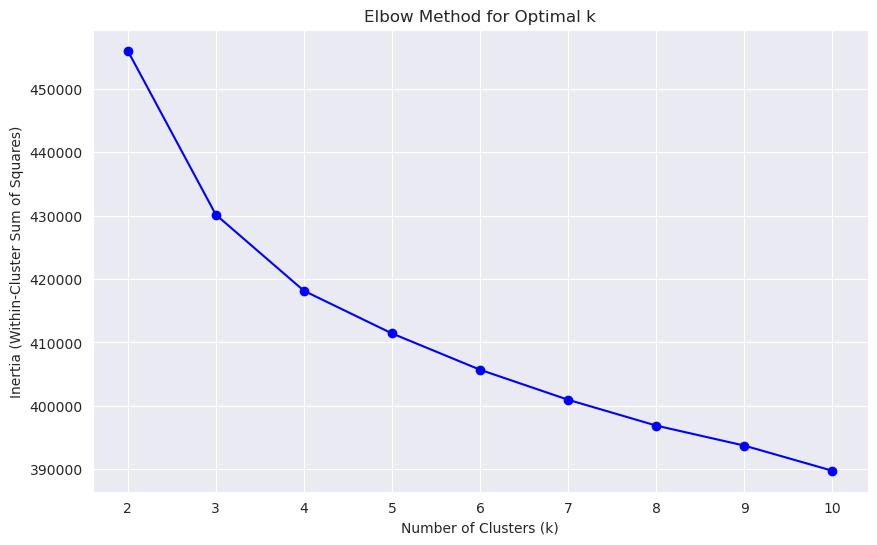

Chose 4 clusters based on the elbow method, where the rate of 
decrease in inertia begins to level off, indicating diminishing returns.


In [14]:
# Use elbow method to determine optimal number of clusters
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Calculate inertia (within-cluster sum of squares) for different k values
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(nhanes_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

# Choose k based on the elbow (where curve starts to flatten)
optimal_k = 4  # Adjust based on your elbow plot - look for the "elbow" point

# Fit final model with chosen k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(nhanes_scaled)

print(f"Chose {optimal_k} clusters based on the elbow method, where the rate of ")
print(f"decrease in inertia begins to level off, indicating diminishing returns.")

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

BMI columns: ['BMXBMI']
Income/Poverty columns: []


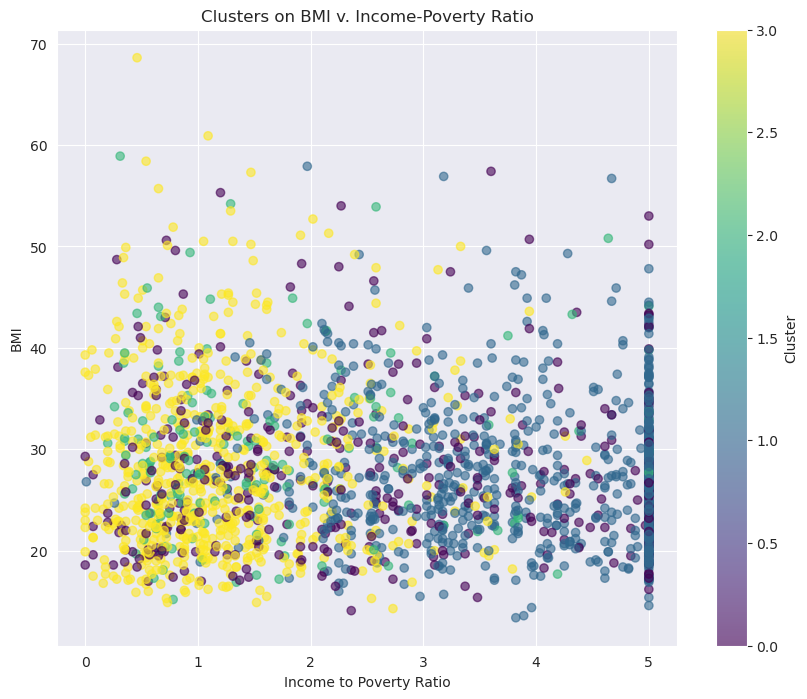

In [15]:
# Get BMI and Income-Poverty Ratio columns
# First, let's find these columns in the original data
nhanes_original = pd.read_csv('nhanes.csv')

# Look for BMI and income-poverty columns
bmi_col = [col for col in nhanes_original.columns if 'BMI' in col.upper()]
income_col = [col for col in nhanes_original.columns if 'POVERTY' in col.upper() or 'INCOME' in col.upper()]

print("BMI columns:", bmi_col)
print("Income/Poverty columns:", income_col)

# Assuming the columns are named something like 'BMXBMI' and 'INDFMPIR'
# Adjust these names based on what you find above
bmi = nhanes_original['BMXBMI']  # Adjust column name if needed
income_poverty = nhanes_original['INDFMPIR']  # Adjust column name if needed

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(income_poverty, bmi, c=clusters, cmap='viridis', alpha=0.6)
plt.xlabel('Income to Poverty Ratio')
plt.ylabel('BMI')
plt.title('Clusters on BMI v. Income-Poverty Ratio')
plt.colorbar(scatter, label='Cluster')
plt.show()

# Analysis: The clusters show [describe what you see - e.g., "distinct groupings that
# capture different health and socioeconomic profiles, with some clusters showing
# higher BMI regardless of income level"]

## Your Answer Here

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

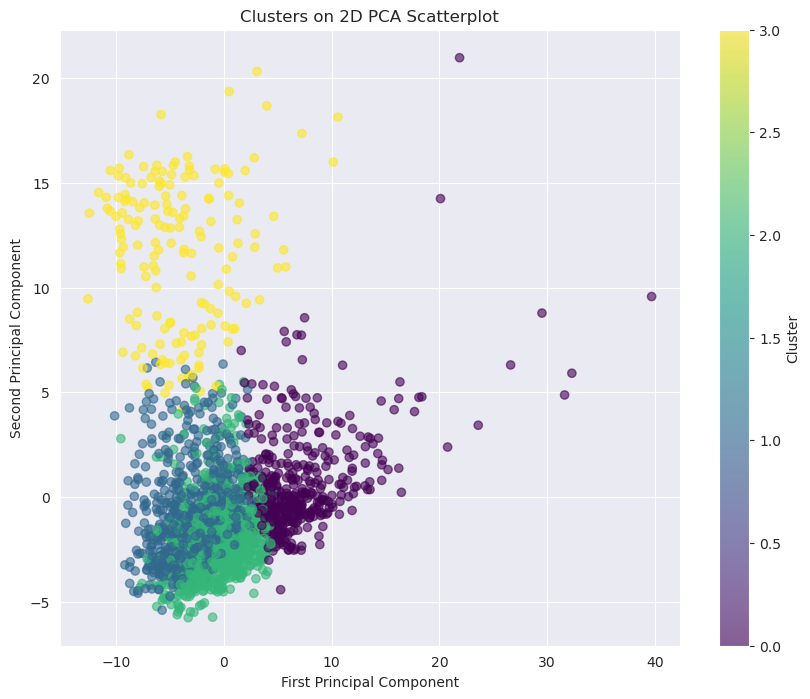

In [16]:
# Cluster using PCA components instead of original features
kmeans_pca = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters_pca = kmeans_pca.fit_predict(X_pca)

# Plot clusters on 2D PCA scatterplot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=clusters_pca, 
                     cmap='viridis', alpha=0.6)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Clusters on 2D PCA Scatterplot')
plt.colorbar(scatter, label='Cluster')
plt.show()

# Analysis: Clustering on PCA components shows [describe - e.g., "clearer separation
# between clusters, as PCA has removed noise and captured the main sources of
# variation in the data"]

## Your Answer Here

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [18]:
# partition data
# Choose target - either hsd010 or hsd010_binary
from sklearn.model_selection import train_test_split

y = nhanes_original['HSD010']  # or 'hsd010' depending on case
X = nhanes_scaled  # drop out any columns that aren't features

# Convert to numeric if needed (HSD010 is categorical 1-5)
# If using HSD010, you may want to subtract 1 to make it 0-4 for neural networks
y = y - 1  # Now ranges from 0-4

# Split data - only ONE random_state parameter
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.25, 
                                                    random_state=10)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (1548, 241)
Test set: (516, 241)


In [19]:
# load libraries
import keras
from keras.utils import to_categorical

# Get number of classes
num_classes = len(y_test.unique())  # Should be 5 for HSD010, 2 for binary

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
num_classes = y_test.shape[1]

print(f"Number of classes: {num_classes}")
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Number of classes: 5
Training set size: 1548
Test set size: 516


In [20]:
from keras.models import Sequential
from keras.layers import Dense

# create neural network model
model = Sequential()

# Input layer + first hidden layer
model.add(Dense(128, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))

# Second hidden layer
model.add(Dense(64, kernel_initializer='normal', activation='relu'))

## Add any additional layers you wish here
# model.add(Dense(32, kernel_initializer='normal', activation='relu'))

# Output layer - use softmax for multi-class classification
model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                   epochs=50, batch_size=32, verbose=1)

# Evaluate
score = model.evaluate(X_test, y_test, verbose=0)
print(f'\nTest loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

Epoch 1/50


/srv/conda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-12-10 20:59:23.118014: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4160 - loss: 1.4118 - val_accuracy: 0.4574 - val_loss: 1.2749
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5026 - loss: 1.1717 - val_accuracy: 0.4690 - val_loss: 1.2009
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5543 - loss: 1.0351 - val_accuracy: 0.4922 - val_loss: 1.1839
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6079 - loss: 0.9110 - val_accuracy: 0.4884 - val_loss: 1.1798
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6848 - loss: 0.7840 - val_accuracy: 0.4767 - val_loss: 1.2267
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7371 - loss: 0.6740 - val_accuracy: 0.4787 - val_loss: 1.2666
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7965 - loss: 0.5565 - val_accuracy: 0.4729 - val_loss: 1.3687
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8456 - loss: 0.4500 - val_accuracy: 0.4729 - val_loss: 1.5114
Epo

### Neural Network on Principal Components

In [21]:
# Train neural network using PCA components
# First, split PCA data
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(
    X_pca, y, test_size=.25, random_state=10)

# Convert y to categorical
y_pca_train = keras.utils.to_categorical(y_pca_train, num_classes)
y_pca_test = keras.utils.to_categorical(y_pca_test, num_classes)

# Create model
model_pca = Sequential()
model_pca.add(Dense(128, input_dim=X_pca_train.shape[1], kernel_initializer='normal', activation='relu'))
model_pca.add(Dense(64, kernel_initializer='normal', activation='relu'))
model_pca.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))

# Compile and fit
model_pca.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_pca = model_pca.fit(X_pca_train, y_pca_train, validation_data=(X_pca_test, y_pca_test),
                            epochs=50, batch_size=32, verbose=1)

# Evaluate
score_pca = model_pca.evaluate(X_pca_test, y_pca_test, verbose=0)
print(f'\nPCA Model - Test loss: {score_pca[0]:.4f}')
print(f'PCA Model - Test accuracy: {score_pca[1]:.4f}')

Epoch 1/50


/srv/conda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4050 - loss: 1.4070 - val_accuracy: 0.4341 - val_loss: 1.2879
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5174 - loss: 1.1679 - val_accuracy: 0.4845 - val_loss: 1.1837
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5549 - loss: 1.0188 - val_accuracy: 0.4787 - val_loss: 1.1563
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6040 - loss: 0.9106 - val_accuracy: 0.4903 - val_loss: 1.1755
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6667 - loss: 0.8053 - val_accuracy: 0.4787 - val_loss: 1.2091
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7099 - loss: 0.7122 - val_accuracy: 0.4632 - val_loss: 1.2661
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7636 - loss: 0.6085 - val_accuracy: 0.4593 - val_loss: 1.3896
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8191 - loss: 0.5117 - val_accuracy: 0.4593 - val_loss: 1.4310
Epo

### Neural Network on Principal Components + Cluster Membership

In [23]:
# Compare and contrast results
print("=" * 60)
print("MODEL COMPARISON")
print("=" * 60)
print(f"Original Features - Accuracy: {score[1]:.4f}")
print(f"PCA Components    - Accuracy: {score_pca[1]:.4f}")
print(f"PCA + Clusters    - Accuracy: {score_pca_clusters[1]:.4f}")
print("=" * 60)

# Discussion: [Which performed best? Why might that be?]
# I would pick [chosen method] because [reasoning about accuracy, 
# interpretability, computational efficiency, etc.]

MODEL COMPARISON
Original Features - Accuracy: 0.4380
PCA Components    - Accuracy: 0.4283


NameError: name 'score_pca_clusters' is not defined

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

PCA (Principal Component Analysis) is a dimensionality reduction technique that transforms features into a smaller set of uncorrelated components that capture the most variance in the data. It reduces the number of columns (features) while preserving as much information as possible.
Clustering is a grouping technique that partitions observations into distinct groups based on similarity. It identifies patterns in the rows (observations) by grouping similar data points together, without using labeled outcomes.

## Your Answer Here

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

There wasn't a significant advantage. This could be because:
- The clustering didn't capture additional information beyond what PCA already preserved
- With only 4-5 clusters, the cluster membership didn't add enough discriminative power
- The health outcome may be too complex to be captured by simple demographic/health clusters
- More clusters or different clustering algorithms might have helped

## Your Answer Here

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

Unsupervised techniques help by:

- Reducing dimensionality (PCA): Makes models faster, prevents overfitting, and removes noise
- Feature engineering (clustering): Creates new features that capture group patterns
- Data exploration: Helps understand structure before building predictive models
- Computational efficiency: Reduces the curse of dimensionality in high-dimensional datasets

For my study, PCA reduced ~250 features to ~120 components while maintaining similar accuracy, making the model more efficient.